## Tutorial from 
https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html

Needs tf v1

In [1]:
import tensorflow as tf
slim = tf.contrib.slim
import sys
sys.path.append('/elena/models/tf-models/slim')
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
from nets import inception
from preprocessing import inception_preprocessing

In [3]:
session = tf.Session()


In [4]:
image_size = inception.inception_v3.default_image_size
def transform_img_fn(path_list):
    out = []
    for f in path_list:
        image_contents = tf.read_file(f)
        image_raw = tf.image.decode_jpeg(image_contents, channels=3)
        image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
        out.append(image)
                    
    return session.run([out])[0]

In [5]:
def transform_arr_fn(imgList):
    out = []
    for img in imgList:
        image_raw = tf.convert_to_tensor(img)
        image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
        out.append(image)
                    
    return session.run([out])[0]

In [7]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\tools")
import hsi_io as io
import hsi_decompositions as dc

In [8]:
from datasets import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()

from itertools import islice
dict(islice(names.items(), 0, 5))

{0: 'background',
 1: 'tench, Tinca tinca',
 2: 'goldfish, Carassius auratus',
 3: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 4: 'tiger shark, Galeocerdo cuvieri'}

In [9]:
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))
processed_images.shape

TensorShape([Dimension(None), Dimension(299), Dimension(299), Dimension(3)])

In [10]:
import os
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

checkpoints_dir = '/elena/models/tf-models/slim/pretrained'
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)



Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Restoring parameters from /elena/models/tf-models/slim/pretrained\inception_v3.ckpt


In [11]:
def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})

# For rgb composite


317 cicada, cicala 0.017888993
127 isopod 0.027763559
953 fig 0.056831114
125 crayfish, crawfish, crawdad, crawdaddy 0.070578896
70 trilobite 0.27943525


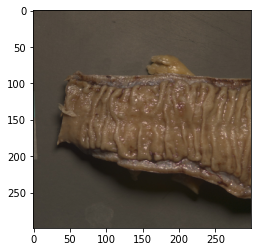

In [12]:
images = transform_img_fn(["/elena/Google Drive/titech/research/experiments/output/hsi/database/test_tissue/rgb/tissue1.jpg"])

# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = predict_fn(images)
for x in preds.argsort()[0][-5:]:
    print(x, names[x], preds[0,x])

In [13]:
image = images[0]

In [14]:
from lime import lime_image
import time

In [19]:
explainer = lime_image.LimeImageExplainer()

In [16]:
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image.astype('double'), predict_fn, top_labels=5, hide_color=0, num_samples=1000)
print (time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

24.750086307525635


In [17]:
from skimage.segmentation import mark_boundaries

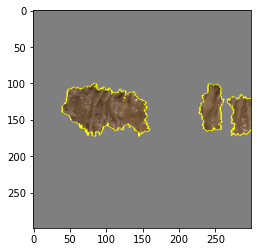

In [18]:
temp, mask = explanation.get_image_and_mask(70, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

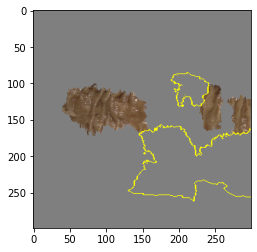

In [20]:
emp, mask = explanation.get_image_and_mask(953 , positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

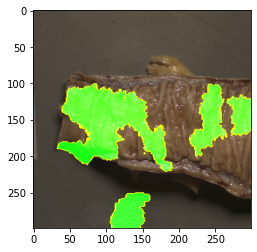

In [21]:
temp, mask = explanation.get_image_and_mask(70 , positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

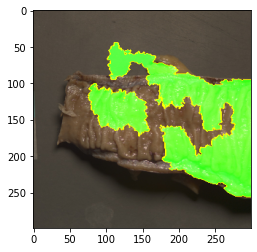

In [22]:
temp, mask = explanation.get_image_and_mask(317, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [28]:
imgList = io.load_hsi("/elena/Google Drive/titech/research/experiments/output/hsi/database/test_tissue/pca")
print(len(imgList))
print(imgList[0].shape)

2
(1376, 1024, 3)


In [29]:
st = np.array(imgList[1].shape)
imCrop = crop_image_middle(imgList[0], st)

sameDimImage = imgList
sameDimImage[0] = imCrop
sameDimImage = np.array(sameDimImage)
print(sameDimImage.shape)

(2, 384, 560, 3)


In [30]:
st = np.array(sameDimImage.shape) 
X = sameDimImage.reshape(st[0]*st[1] * st[2], st[3])

In [31]:
from sklearn.preprocessing import StandardScaler    

In [32]:
def get_scaling(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler
scaler = get_scaling(X)
Xtrans = scaler.transform(X)
normImage = sameDimImage.reshape(st[0], st[1], st[2], st[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


634 loupe, jeweler's loupe 0.0086076055
60 vine snake 0.008716402
663 modem 0.008930393
917 web site, website, internet site, site 0.011596152
561 football helmet 0.019558622


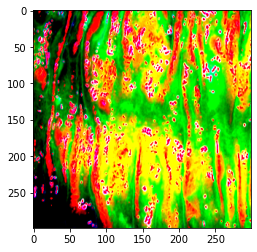

In [33]:
# Predictions for raw images 
images1 = transform_arr_fn(sameDimImage)

# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images1[0] / 2 + 0.5)
preds = predict_fn(images1)

for x in preds.argsort()[0][-5:]:
    print(x, names[x], preds[0,x])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


359 polecat, fitch, foulmart, foumart, Mustela putorius 0.011076958
127 isopod 0.013804709
112 nematode, nematode worm, roundworm 0.013903772
917 web site, website, internet site, site 0.021181969
363 badger 0.026096214


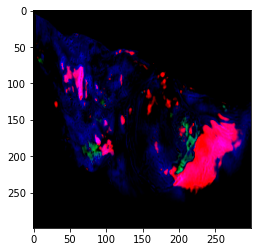

In [34]:
plt.imshow(images1[1] / 2 + 0.5)
for x in preds.argsort()[1][-5:]:
    print(x, names[x], preds[1,x])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


634 loupe, jeweler's loupe 0.0086076055
60 vine snake 0.008716402
663 modem 0.008930393
917 web site, website, internet site, site 0.011596152
561 football helmet 0.019558622


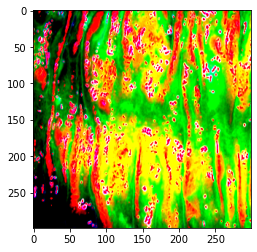

In [35]:
# Predictions for norm images 

images = transform_arr_fn(normImage)

# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = predict_fn(images)
for x in preds.argsort()[0][-5:]:
    print(x, names[x], preds[0,x])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


359 polecat, fitch, foulmart, foumart, Mustela putorius 0.011076958
127 isopod 0.013804709
112 nematode, nematode worm, roundworm 0.013903772
917 web site, website, internet site, site 0.021181969
363 badger 0.026096214


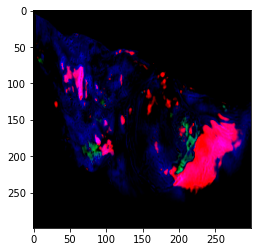

In [36]:
plt.imshow(images[1] / 2 + 0.5)
for x in preds.argsort()[1][-5:]:
    print(x, names[x], preds[1,x])

In [37]:
image = images[1]
explainer = lime_image.LimeImageExplainer()

tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image.astype('double'), predict_fn, top_labels=5, hide_color=0, num_samples=1000)
print (time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

30.32447075843811


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


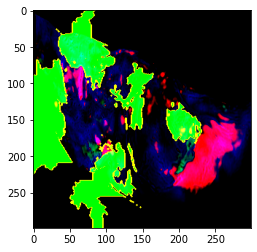

In [38]:
temp, mask = explanation.get_image_and_mask(363 , positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


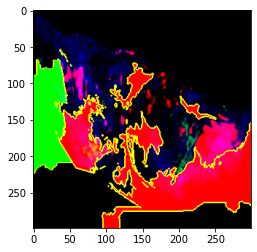

In [39]:
temp, mask = explanation.get_image_and_mask(917, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

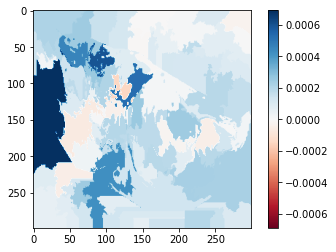

In [40]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [41]:
print(explanation.top_labels)

[363, 917, 112, 127, 359]


In [42]:
images = transform_img_fn(["/elena/Google Drive/titech/research/experiments/output/hsi/database/test_tissue/rgb/tissue2.jpg"])

3 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias 0.020995185
767 rotisserie 0.032993935
6 electric ray, crampfish, numbfish, torpedo 0.053126607
70 trilobite 0.15001097
118 chambered nautilus, pearly nautilus, nautilus 0.26118118


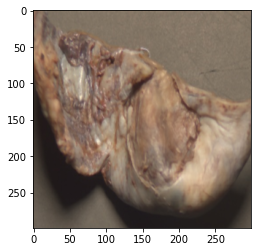

In [43]:
  
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = predict_fn(images)
for x in preds.argsort()[0][-5:]:
    print(x, names[x], preds[0,x])
    

In [44]:
image = images[0]
explainer = lime_image.LimeImageExplainer()

tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image.astype('double'), predict_fn, top_labels=5, hide_color=0, num_samples=1000)
print (time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

32.20983362197876


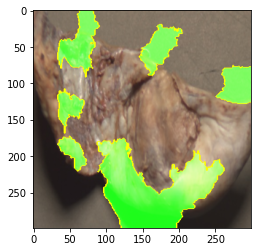

In [45]:
temp, mask = explanation.get_image_and_mask(118 , positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

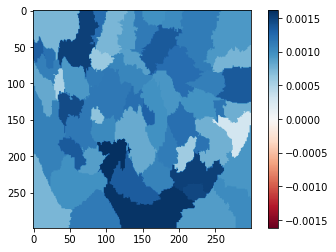

In [46]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()